Notes on importing externally-defined models

Note: Code should be run in a NLP Medulla kernel

In [10]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import networkx
import numpy as np
import os.path
from random import choice
import tempfile
import typing as tp
import flybrainlab as fbl

import linecache
import os
import tracemalloc

import netpyne
from netpyne.specs import netParams, SimConfig
from netpyne import conversion, sim

from brian2 import *

import src.NeuroNLP_to_Brian_Netpyne.nlpToNetpyne as toNet
import src.NeuroNLP_to_Brian_Netpyne.nlptoBrian2 as toBri

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define variables and helper functions

In [11]:
# Query and files
query = "show cholinergic neurons presynaptic to T4a neuron in column C with at least 5 synapses"
path = "img/import_model/"

# Cells Present: Mi1-C, Mi1-L, Tm3-C-ant, Tm3-K-ant, Tm3-home-post

## NetPyNE

All imported cell models should be in the NEURON .mod format (see [here](https://nrn.readthedocs.io/en/latest/coreneuron/running-a-simulation.html) for additional information. Additionally, see [here](https://senselab.med.yale.edu/ModelDB/) for a database of neuron models).

Before executing code, all .mod files must be in the same folder as the .ipnyb notebook. Then, you need to open up the console, direct to the directory containing the script and the .mod files, and run the "nrnivmodl" command. If everything is set up correctly, this should generate the necessary files in the directory for the code to run.

In the following case, we have downloaded the Izhikevich 2007b neuron, and can now modify its parameters if we specify that we're using its model. (Download [here](http://www.netpyne.org/_downloads/803a7312bae028b7a24ba7f3e28de705/izhi2007b.mod))

In [12]:
# Default Mechanisms
stim_mech = {'bkg': {'type': 'NetStim', 'rate': 10, 'noise': 0}} # Stimulation mechanism
default_syn = {'mod': 'Exp2Syn', 'tau1': 0.1, 'tau2': 5.0, 'e': 0} # Excitatory synapse mechanism

# Izhi
Izhi = {'secs': {}}
Izhi['secs']['soma'] = {'geom': {}, 'pointps': {}}
Izhi['secs']['soma']['geom'] = {'diam': 18.8, 'L': 18.8, 'Ra': 123.0}
Izhi['secs']['soma']['pointps']['Izhi'] = {'mod':'Izhi2007b', # Izhikevich 2007b neuron model is specified here
                                           'C':1,
                                           'k':0.7,
                                           'vr':-60,
                                           'vt':-40,
                                           'vpeak':35,
                                           'a':0.03,
                                           'b':-2,
                                           'c':-50,
                                           'd':100,
                                           'celltype':1}

[FBL NLP 2023-08-25 11:46:52,907] NLP successfully parsed query.

Start time:  2023-08-25 11:46:57.239846

Creating network of 5 cell populations on 1 hosts...
  Number of cells on node 0: 5 
  Done; cell creation time = 0.00 s.
Making connections...
  Number of connections on node 0: 12 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 3 traces of 1 types on node 0

Running simulation using NEURON for 1000.0 ms...
  Done; run time = 0.04 s; real-time ratio: 23.05.

Gathering data...
  Done; gather time = 0.00 s.

Analyzing...
  Cells: 5
  Connections: 13 (2.60 per cell)
  Spikes: 1023 (204.60 Hz)
  Simulated time: 1.0 s; 1 workers
  Run time: 0.04 s
Preparing spike data...
Plotting raster...
Plotting recorded cell traces ... cell


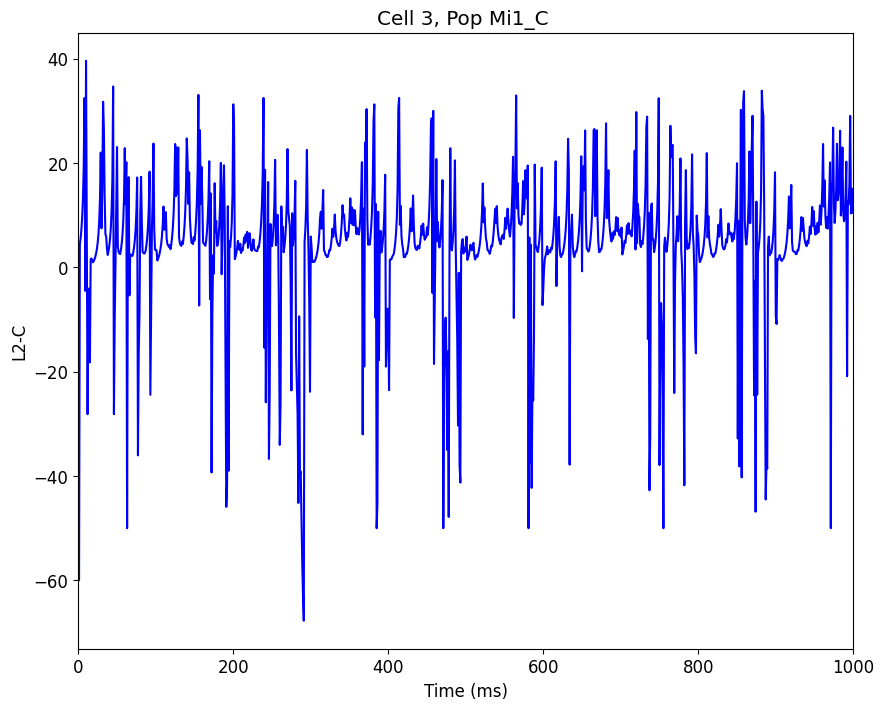

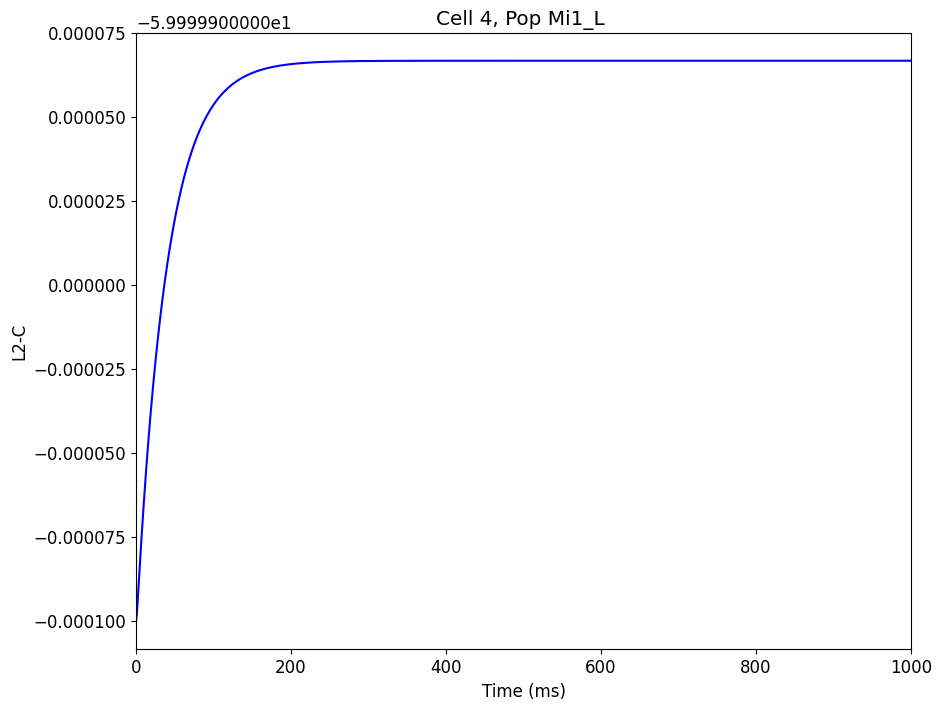

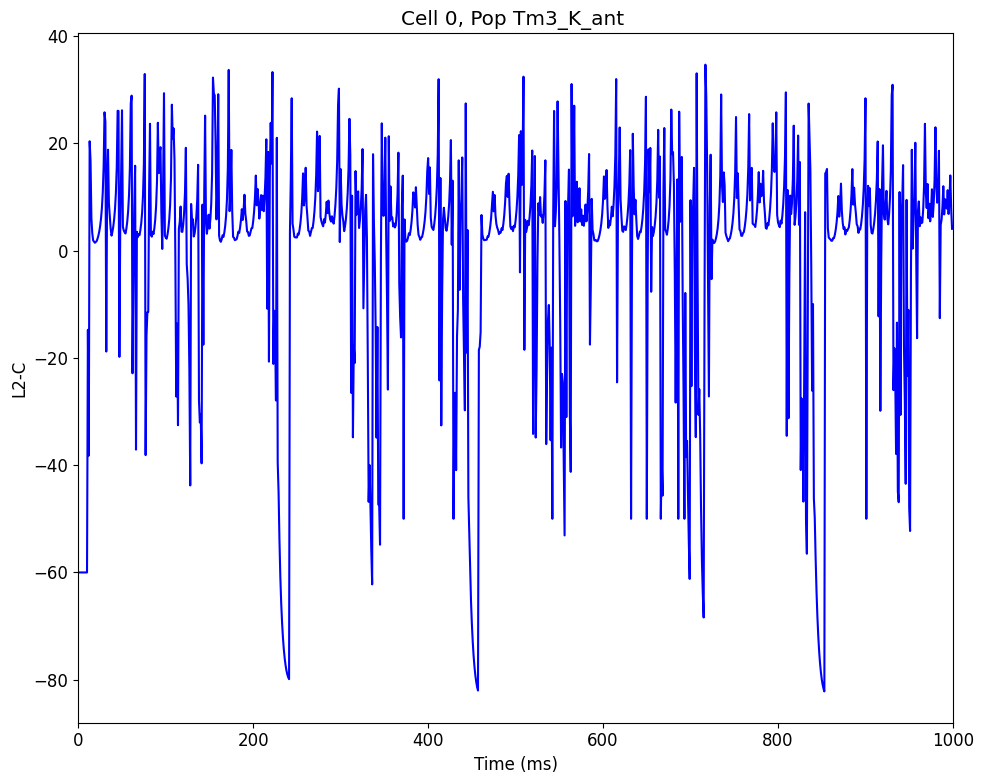

Plotting 2D representation of network cell locations and connections...


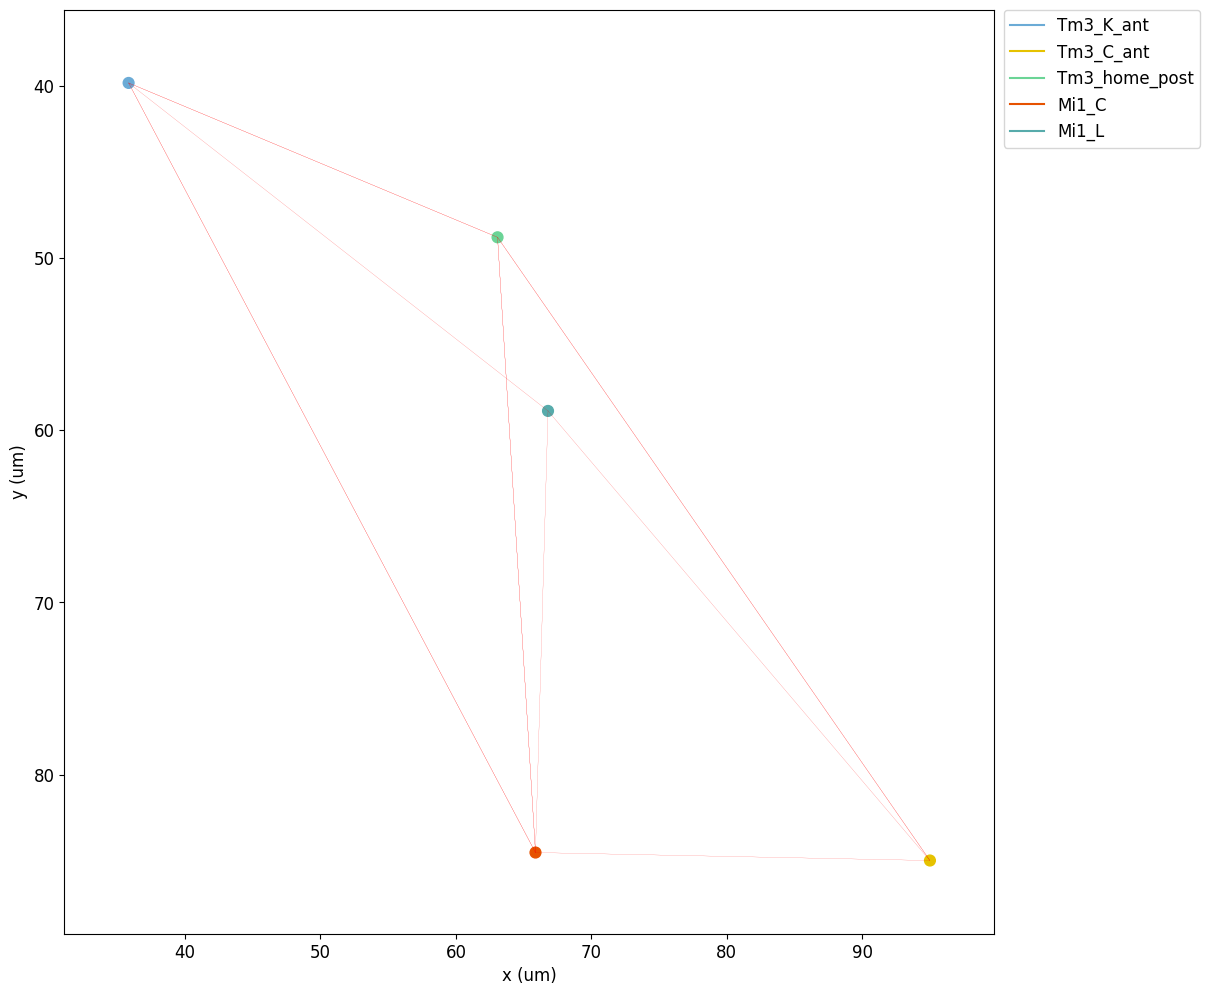

Plotting connectivity matrix...


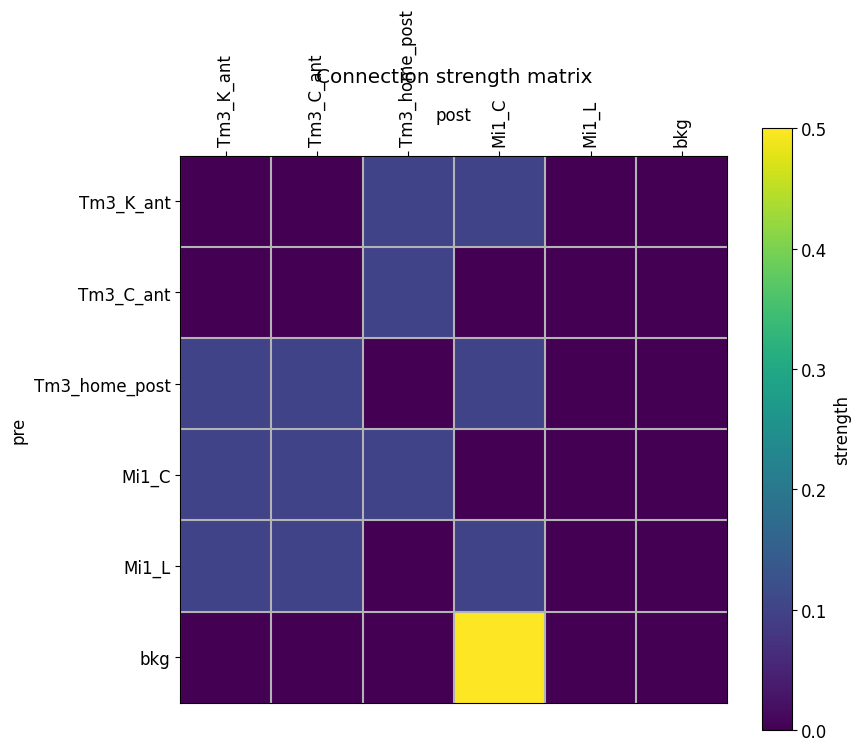

  Done; plotting time = 1.51 s

Total time = 1.56 s


In [13]:
my_client = fbl.get_client()
res = my_client.executeNLPquery(query)

# Default cell is basic NEURON hh neuron, Tm3-K-ant and Tm3-home-post are defined as Izhikevich neurons (2007 version)
networkParameters, simConfig = toNet.model_gen(client=my_client,
                                               res=res,
                                               filename=path+"Import_Model",
                                               default_mech=default_syn,
                                               default_cell=Izhi,
                                               stim_sources=stim_mech,
                                               stim_targets={'Mi1_C': {'source': 'bkg', 'weight': 0.5, 'delay': 1, 'mech': 'exc'}},
                                               record_names=['Mi1_C', 'Mi1_L', 'Tm3_K_ant'],
                                               maintain_morphology=False)

toNet.simulate(networkParameters, simConfig)

## Brian2

Brian2 does not support externally-defined cell models.